In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from datetime import datetime
from tqdm.notebook import tqdm
import random
import zipfile
from google.colab import drive, files

In [3]:
# Kiểm tra GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
base_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/data'

In [5]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [11]:
# Kiểm tra cấu trúc dữ liệu
def check_data_structure(data_dir, type_name):
    if not os.path.exists(data_dir):
        print(f"Thư mục {type_name} không tồn tại: {data_dir}")
        return False

    class_dirs = os.listdir(data_dir)
    print(f"Thư mục {type_name} có {len(class_dirs)} lớp (sinh viên): {class_dirs}")

    total_images = 0
    class_distribution = {}

    for class_dir in class_dirs:
        class_path = os.path.join(data_dir, class_dir)
        if os.path.isdir(class_path):
            images = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            num_images = len(images)
            total_images += num_images
            class_distribution[class_dir] = num_images

    print(f"Tổng số ảnh trong {type_name}: {total_images}")
    print(f"Phân bố số lượng ảnh theo lớp: {class_distribution}\n")

    return True

In [15]:
train_ok = check_data_structure(train_dir, "train")
val_ok = check_data_structure(val_dir, "validation")
test_ok = check_data_structure(test_dir, "test")

Thư mục train có 13 lớp (sinh viên): ['Anh', 'Binh', 'Duc', 'banAnh', 'Hoang', 'Hung', 'Lan', 'KAnh', 'Nhung', 'NAnh', 'Long', 'Son', 'TAnh']
Tổng số ảnh trong train: 881
Phân bố số lượng ảnh theo lớp: {'Anh': 68, 'Binh': 70, 'Duc': 66, 'banAnh': 68, 'Hoang': 68, 'Hung': 69, 'Lan': 69, 'KAnh': 68, 'Nhung': 68, 'NAnh': 66, 'Long': 67, 'Son': 67, 'TAnh': 67}

Thư mục validation có 13 lớp (sinh viên): ['Anh', 'Binh', 'Duc', 'banAnh', 'Hung', 'Hoang', 'KAnh', 'Lan', 'Son', 'Nhung', 'NAnh', 'Long', 'TAnh']
Tổng số ảnh trong validation: 253
Phân bố số lượng ảnh theo lớp: {'Anh': 19, 'Binh': 17, 'Duc': 22, 'banAnh': 19, 'Hung': 18, 'Hoang': 20, 'KAnh': 19, 'Lan': 17, 'Son': 20, 'Nhung': 21, 'NAnh': 21, 'Long': 20, 'TAnh': 20}

Thư mục test có 13 lớp (sinh viên): ['Anh', 'Duc', 'Binh', 'banAnh', 'Hoang', 'Lan', 'Hung', 'KAnh', 'NAnh', 'Long', 'Nhung', 'TAnh', 'Son']
Tổng số ảnh trong test: 166
Phân bố số lượng ảnh theo lớp: {'Anh': 13, 'Duc': 12, 'Binh': 13, 'banAnh': 13, 'Hoang': 12, 'Lan': 1

In [16]:
# Cấu hình tham số
IMG_SIZE = 224  # Kích thước đầu vào cho MobileNetV2
BATCH_SIZE = 32
EPOCHS = 30

In [17]:
# Tạo danh sách các lớp (mỗi lớp là một sinh viên)
classes = sorted(os.listdir(train_dir))
num_classes = len(classes)

print(f"Số lượng lớp: {num_classes}")
print(f"Các lớp: {classes}")

Số lượng lớp: 13
Các lớp: ['Anh', 'Binh', 'Duc', 'Hoang', 'Hung', 'KAnh', 'Lan', 'Long', 'NAnh', 'Nhung', 'Son', 'TAnh', 'banAnh']


In [18]:
# Data augmentation cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Chỉ rescale cho tập validation và test
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 881 images belonging to 13 classes.
Found 253 images belonging to 13 classes.
Found 166 images belonging to 13 classes.


In [20]:
def show_batch(image_batch, label_batch, class_indices):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    plt.figure(figsize=(10, 10))
    for i in range(min(25, len(image_batch))):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image_batch[i])

        # Lấy index của lớp được dự đoán (argmax)
        class_idx = np.argmax(label_batch[i])
        class_name = idx_to_class[class_idx]

        plt.title(class_name, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [21]:
images, labels = next(train_generator)

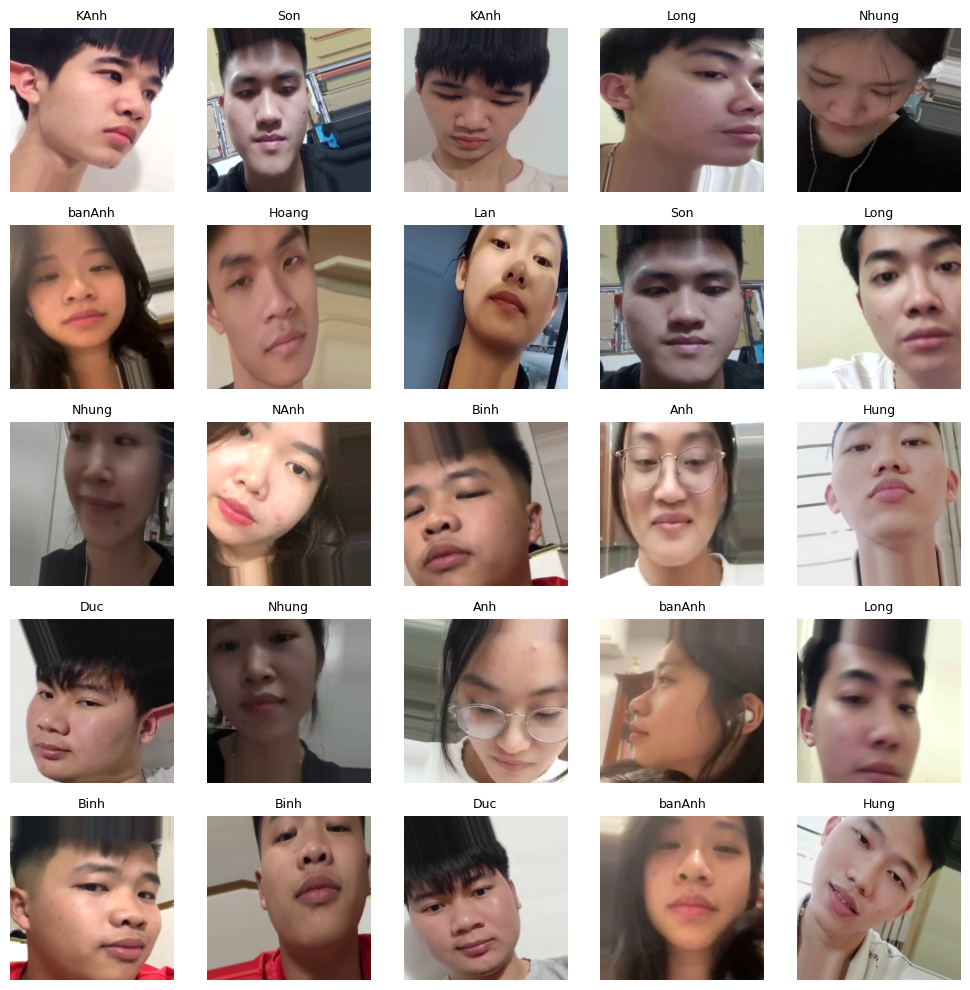

In [22]:
show_batch(images, labels, train_generator.class_indices)

In [23]:
def build_model(num_classes):
    # Tải MobileNetV2 pre-trained trên ImageNet, không bao gồm lớp fully connected
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )

    # Đóng băng các lớp của mô hình cơ sở
    for layer in base_model.layers:
        layer.trainable = False

    # Thêm các lớp mới
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Lớp output cho nhận diện khuôn mặt (số lượng lớp = số sinh viên)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Tạo model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Biên dịch model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

In [24]:
model, base_model = build_model(num_classes)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,101,197 (15.64 MB)

 Trainable params: 1,843,213 (7.03 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Huấn luyện mô hình - Giai đoạn 1: Train lớp top

In [27]:
# Thư mục để lưu mô hình
model_dir = '/content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models'
os.makedirs(model_dir, exist_ok=True)

In [28]:
# Tạo tên mô hình với timestamp
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_name = f"face_recognition_model_{timestamp}"
model_path = os.path.join(model_dir, model_name)
os.makedirs(model_path, exist_ok=True)

In [30]:
# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage1.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

tensorboard = TensorBoard(
    log_dir=os.path.join(model_path, 'logs'),
    histogram_freq=1
)

callbacks = [checkpoint, early_stopping, reduce_lr, tensorboard]

In [31]:
# Tính số bước trên mỗi epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = val_generator.samples // BATCH_SIZE

In [32]:
# Huấn luyện model - Giai đoạn 1 (chỉ train các lớp top mới thêm vào)
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.2607 - loss: 2.3741 
Epoch 1: val_accuracy improved from -inf to 0.84821, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250403-201924/best_model_stage1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 437s 16s/step - accuracy: 0.2663 - loss: 2.3549 - val_accuracy: 0.8482 - val_loss: 0.5164 - learning_rate: 0.0010
Epoch 2/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6250 - loss: 1.1152

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.84821 to 0.86161, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250403-201924/best_model_stage1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 568ms/step - accuracy: 0.6250 - loss: 1.1152 - val_accuracy: 0.8616 - val_loss: 0.4587 - learning_rate: 0.0010
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7525 - loss: 0.6849
Epoch 3: val_accuracy improved from 0.86161 to 0.98214, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250403-201924/best_model_stage1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 819ms/step - accuracy: 0.7539 - loss: 0.6818 - val_accuracy: 0.9821 - val_loss: 0.1387 - learning_rate: 0.0010
Epoch 4/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8125 - loss: 0.5765
Epoch 4: val_accuracy improved from 0.98214 to 0.99107, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250403-201924/best_model_stage1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8125 - loss: 0.5765 - val_accuracy: 0.9911 - val_loss: 0.1263 - learning_rate: 0.0010
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8669 - loss: 0.4304
Epoch 5: val_accuracy did not improve from 0.99107
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 766ms/step - accuracy: 0.8674 - loss: 0.4287 - val_accuracy: 0.9911 - val_loss: 0.0696 - learning_rate: 0.0010
Epoch 6/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8438 - loss: 0.3783
Epoch 6: val_accuracy did not improve from 0.99107
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.8438 - loss: 0.3783 - val_accuracy: 0.9821 - val_loss: 0.0783 - learning_rate: 0.0010
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.9090 - loss: 0.2852
Epoch 7: val_accuracy improved from 0.99107 to 0.99554, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250403-201924/best_model_stage1.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 981ms/step - accuracy: 0.9089 - loss: 0.2847 - val_accuracy: 0.9955 - val_loss: 0.0520 - learning_rate: 0.0010
Epoch 8/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 1.0000 - loss: 0.1162
Epoch 8: val_accuracy did not improve from 0.99554
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 0.1162 - val_accuracy: 0.9911 - val_loss: 0.0526 - learning_rate: 0.0010
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9202 - loss: 0.2547
Epoch 9: val_accuracy did not improve from 0.99554
27/27 ━━━━━━━━━━━━━━━━━━━━ 33s 829ms/step - accuracy: 0.9197 - loss: 0.2554 - val_accuracy: 0.9732 - val_loss: 0.0769 - learning_rate: 0.0010
Epoch 10/30
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8750 - loss: 0.3167
Epoch 10: val_accuracy did not improve from 0.99554

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.8750 - loss: 0.3167 - val_accu

## Fine-tuning - Giai đoạn 2: Tinh chỉnh một số lớp của mô hình cơ sở

In [33]:
# Mở khóa các lớp cuối của base model
# Đóng băng các lớp đầu, mở khóa các lớp cuối để fine-tune
for layer in base_model.layers[:-30]:  # Giữ các lớp đầu đóng băng
    layer.trainable = False
for layer in base_model.layers[-30:]:  # Mở khóa 30 lớp cuối
    layer.trainable = True

In [35]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Learning rate thấp hơn cho fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [36]:
# Cập nhật callbacks cho giai đoạn 2
checkpoint_stage2 = ModelCheckpoint(
    os.path.join(model_path, 'best_model_stage2.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks_stage2 = [checkpoint_stage2, early_stopping, reduce_lr, tensorboard]

In [37]:
# Huấn luyện giai đoạn 2 - Fine-tuning
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,  # Thường ít epochs hơn cho fine-tuning
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_stage2,
    verbose=1
)

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6500 - loss: 1.1340
Epoch 1: val_accuracy improved from -inf to 0.99107, saving model to /content/drive/Othercomputers/My Laptop/Documents/Graduate_thesis/models/face_recognition_model_20250403-201924/best_model_stage2.h5


27/27 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6504 - loss: 1.1307 - val_accuracy: 0.9911 - val_loss: 0.0518 - learning_rate: 1.0000e-05
Epoch 2/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.7500 - loss: 0.6207
Epoch 2: val_accuracy did not improve from 0.99107
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 0.7500 - loss: 0.6207 - val_accuracy: 0.9911 - val_loss: 0.0523 - learning_rate: 1.0000e-05
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7718 - loss: 0.7400
Epoch 3: val_accuracy did not improve from 0.99107
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7726 - loss: 0.7371 - val_accuracy: 0.9866 - val_loss: 0.0635 - learning_rate: 1.0000e-05
Epoch 4/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7812 - loss: 0.5191
Epoch 4: val_accuracy did not improve from 0.99107

Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.7812 - loss: 0.5191 - val_accu

## 8. Đánh giá mô hình trên tập test

In [39]:
# Tải model tốt nhất
best_model_path = os.path.join(model_path, 'best_model_stage2.h5')
model = load_model(best_model_path)

In [40]:
# Đánh giá trên tập test
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 10s/step - accuracy: 0.9979 - loss: 0.0256
Test accuracy: 0.9937
Test loss: 0.0331


In [41]:
# Dự đoán trên tập test
test_generator.reset()
y_pred = model.predict(test_generator, steps=test_generator.samples // BATCH_SIZE + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Lấy nhãn thực tế
test_labels = test_generator.classes[:len(y_pred_classes)]

# In báo cáo phân loại
class_names = list(test_generator.class_indices.keys())
print("Classification Report:\n")
print(classification_report(test_labels, y_pred_classes, target_names=class_names))

6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step
Classification Report:

              precision    recall  f1-score   support

         Anh       1.00      1.00      1.00        13
        Binh       1.00      1.00      1.00        13
         Duc       1.00      1.00      1.00        12
       Hoang       1.00      1.00      1.00        12
        Hung       1.00      1.00      1.00        13
        KAnh       1.00      1.00      1.00        13
         Lan       1.00      1.00      1.00        14
        Long       1.00      1.00      1.00        13
        NAnh       1.00      1.00      1.00        13
       Nhung       0.92      1.00      0.96        11
         Son       1.00      1.00      1.00        13
        TAnh       1.00      1.00      1.00        13
      banAnh       1.00      0.92      0.96        13

    accuracy                           0.99       166
   macro avg       0.99      0.99      0.99       166
weighted avg       0.99      0.99      0.99       166



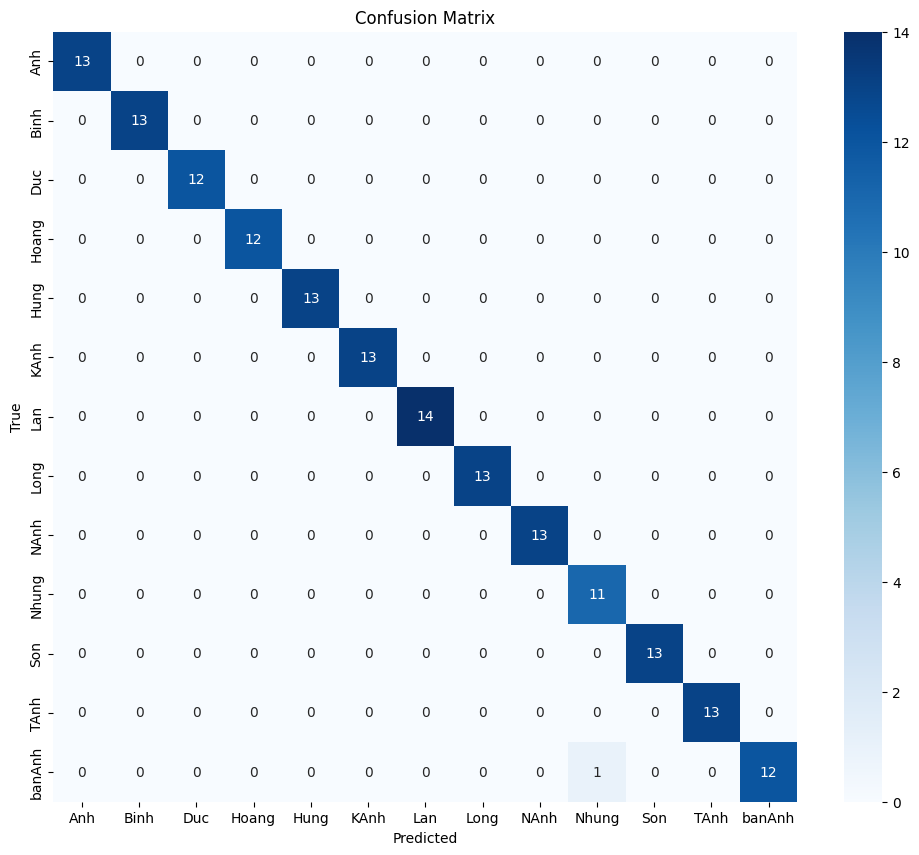

In [42]:
# Vẽ confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Hiển thị các kết quả dự đoán

In [43]:
def show_prediction_examples(test_generator, model, class_indices, num_examples=10):
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Lấy các batch cho đến khi đủ số lượng ví dụ
    examples = []
    count = 0

    for i in range(min(50, len(test_generator))):
        if count >= num_examples:
            break

        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            if count >= num_examples:
                break

            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])
            confidence = y_pred_batch[j][pred_class_idx]

            is_correct = true_class_idx == pred_class_idx

            examples.append({
                'image': x_batch[j],
                'true_class': idx_to_class[true_class_idx],
                'pred_class': idx_to_class[pred_class_idx],
                'confidence': confidence,
                'is_correct': is_correct
            })

            count += 1

    # Hiển thị các ví dụ
    plt.figure(figsize=(15, 4 * num_examples//5 + 4))

    for i, example in enumerate(examples):
        ax = plt.subplot(num_examples//5 + 1, 5, i + 1)

        plt.imshow(example['image'])

        title_color = 'green' if example['is_correct'] else 'red'
        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color=title_color,
            fontsize=9
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [49]:
show_prediction_examples(test_generator, model, test_generator.class_indices, num_examples=50)

Output hidden; open in https://colab.research.google.com to view.

Hiển thị các dự đoán sai trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Tìm thấy 1 dự đoán sai. Hiển thị tối đa 1 ví dụ:


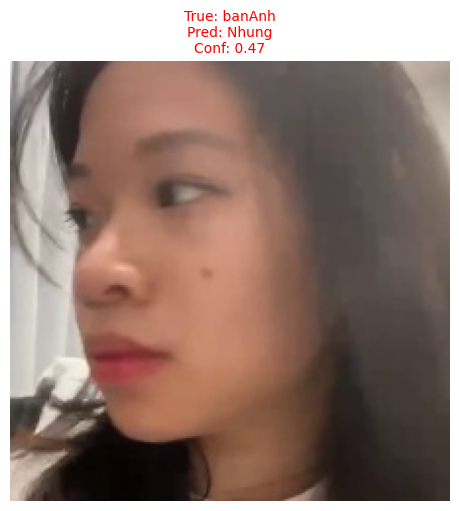

In [50]:
def show_incorrect_predictions(test_generator, model, class_indices, num_examples=15):
    """
    Hiển thị các ví dụ dự đoán sai từ tập test

    Args:
        test_generator: Generator cho tập test
        model: Mô hình đã huấn luyện
        class_indices: Dictionary ánh xạ tên lớp thành index
        num_examples: Số lượng ví dụ sai muốn hiển thị
    """
    # Đảo ngược dictionary class_indices để lấy tên lớp từ index
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Reset generator
    test_generator.reset()

    # Danh sách lưu các dự đoán sai
    incorrect_examples = []

    # Duyệt qua tập test để tìm các dự đoán sai
    for i in range(len(test_generator)):
        x_batch, y_batch = next(test_generator)
        y_pred_batch = model.predict(x_batch)

        for j in range(len(x_batch)):
            true_class_idx = np.argmax(y_batch[j])
            pred_class_idx = np.argmax(y_pred_batch[j])

            # Kiểm tra nếu dự đoán sai
            if true_class_idx != pred_class_idx:
                confidence = y_pred_batch[j][pred_class_idx]

                incorrect_examples.append({
                    'image': x_batch[j],
                    'true_class': idx_to_class[true_class_idx],
                    'pred_class': idx_to_class[pred_class_idx],
                    'confidence': confidence
                })

                # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
                if len(incorrect_examples) >= num_examples:
                    break

        # Nếu đã đủ số lượng ví dụ, dừng vòng lặp
        if len(incorrect_examples) >= num_examples:
            break

    if not incorrect_examples:
        print("Không có dự đoán sai nào được tìm thấy trong tập test!")
        return

    total_found = len(incorrect_examples)
    print(f"Tìm thấy {total_found} dự đoán sai. Hiển thị tối đa {min(num_examples, total_found)} ví dụ:")

    # Hiển thị các ví dụ sai
    rows = (min(num_examples, total_found) // 3) + (1 if min(num_examples, total_found) % 3 > 0 else 0)
    plt.figure(figsize=(15, 5 * rows))

    for i, example in enumerate(incorrect_examples[:num_examples]):
        ax = plt.subplot(rows, 3, i + 1)

        plt.imshow(example['image'])

        plt.title(
            f"True: {example['true_class']}\nPred: {example['pred_class']}\nConf: {example['confidence']:.2f}",
            color='red',
            fontsize=10
        )

        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Thực thi hàm để hiển thị các dự đoán sai
print("Hiển thị các dự đoán sai trên tập test:")
show_incorrect_predictions(test_generator, model, test_generator.class_indices, num_examples=15)

## Vẽ đồ thị quá trình huấn luyện

In [46]:
def plot_training_history(history1, history2=None, title="Training History"):
    plt.figure(figsize=(15, 5))

    # Đồ thị accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Stage 1 Train')
    plt.plot(history1.history['val_accuracy'], label='Stage 1 Validation')


    # Tiếp tục từ đoạn code trước
    if history2:
        # Xác định điểm bắt đầu của stage 2
        stage1_epochs = len(history1.history['accuracy'])
        x_stage2 = range(stage1_epochs, stage1_epochs + len(history2.history['accuracy']))

        plt.plot(x_stage2, history2.history['accuracy'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_accuracy'], label='Stage 2 Validation')

    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Đồ thị loss
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Stage 1 Train')
    plt.plot(history1.history['val_loss'], label='Stage 1 Validation')

    if history2:
        plt.plot(x_stage2, history2.history['loss'], label='Stage 2 Train')
        plt.plot(x_stage2, history2.history['val_loss'], label='Stage 2 Validation')

    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.85)
    plt.show()

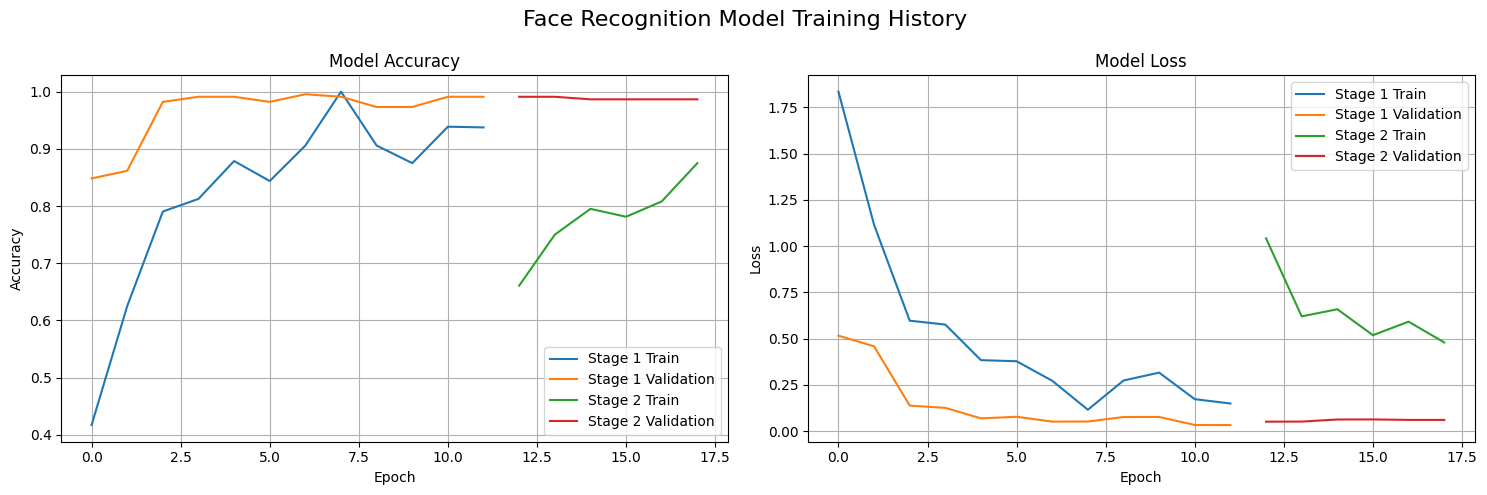

In [47]:
plot_training_history(history_stage1, history_stage2, "Face Recognition Model Training History")

In [48]:
import pickle
with open(os.path.join(model_path, 'history.pkl'), 'wb') as f:
    pickle.dump({
        'stage1': history_stage1.history,
        'stage2': history_stage2.history
    }, f)